In [21]:
import numpy as np
import scipy
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import xarray as xr
from tqdm.notebook import tqdm
# from statsmodels.sandbox.stats.multicomp import multipletests

from allen_v1dd.client import OPhysClient
from allen_v1dd.stimulus_analysis import StimulusAnalysis, LocallySparseNoise
import allen_v1dd.stimulus_analysis.analysis_tools as at
at.set_stylesheet()

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
client = OPhysClient("/Users/chase/Desktop/test_v1dd_data")

In [3]:
sess = client.load_ophys_session(mouse=409828, column=1, volume=4)

In [4]:
for plane in sess.get_planes():
    print(f"Plane {plane}: {sess.get_plane_depth(plane)} µm")

Plane 1: 338 µm
Plane 2: 354 µm
Plane 3: 370 µm
Plane 4: 386 µm
Plane 5: 402 µm
Plane 6: 418 µm


In [5]:
plane = 6
lsn = LocallySparseNoise(sess, plane)

In [6]:
lsn.sweep_responses.shape

(1705, 643)

In [7]:
lsn.n_rois, lsn.n_rois_valid

(643, 243)

In [8]:
valid_rois = np.where(sess.is_roi_valid(plane, conf=0.5))[0]
valid_rois

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  68,  70,  71,  72,  73,  74,  75,  76,  77,  78,  79,
        80,  81,  83,  84,  85,  86,  87,  88,  89,  90,  91,  92,  93,
        94,  95,  96,  97,  99, 100, 101, 103, 104, 105, 106, 107, 108,
       110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122,
       123, 124, 125, 126, 127, 128, 129, 131, 132, 133, 134, 135, 136,
       137, 138, 139, 140, 144, 145, 146, 147, 149, 150, 151, 152, 153,
       154, 155, 156, 157, 158, 159, 160, 162, 163, 164, 167, 168, 169,
       171, 172, 175, 177, 178, 179, 180, 181, 182, 183, 184, 186, 188,
       189, 190, 191, 192, 193, 195, 197, 198, 199, 200, 201, 20

In [25]:
sta = lsn.design_matrix.dot(lsn.sweep_responses) # shape (2*n_pixels, n_rois)
sta = xr.DataArray(sta.T, dims=("roi", "pixel"))
sta

<xarray.DataArray (roi: 643, pixel: 224)>
array([[-0.40804339, -0.07437414,  0.91947646, ...,  0.56602156,
        -0.00914191,  0.87852544],
       [ 0.0855537 , -0.48608303,  1.36043598, ..., -0.43227437,
        -0.83297926,  1.44952841],
       [ 0.01804294, -0.33304657,  1.12834206, ..., -0.33364889,
         0.25498006,  0.3929919 ],
       ...,
       [ 0.28913758, -0.81119728,  0.20990035, ...,  0.37321478,
        -0.13394079,  0.11144792],
       [-0.5188028 , -1.19278962,  0.13058865, ..., -0.42032704,
        -0.05579088,  0.69647591],
       [ 0.16405257, -0.42016652, -0.5345549 , ...,  0.40732443,
        -0.5376893 ,  0.7981574 ]])
Dimensions without coordinates: roi, pixel

In [11]:
spont_traces = sess.get_spont_traces(plane=plane, trace_type="dff")
spont_mean = spont_traces.mean(dim="time") # shape (n_rois,)
spont_std = spont_traces.std(dim="time") # shape (n_rois,)

In [29]:
sta_z_score = (sta - spont_mean) / spont_std
sta_z_score

<xarray.DataArray (roi: 643, pixel: 224)>
array([[ -2.39735088,  -0.63514356,   4.61367946, ...,   2.74697812,
         -0.2906326 ,   4.39740481],
       [  0.72465355,  -4.47158161,  12.31346113, ...,  -3.98245546,
         -7.62490299,  13.12332021],
       [  0.13825672,  -3.38071693,  11.26679613, ...,  -3.38675398,
          2.51307994,   3.89637398],
       ...,
       [  2.01168401,  -5.9012912 ,   1.4418554 , ...,   2.61631881,
         -1.03085219,   0.73384224],
       [ -4.52183019, -10.37667481,   1.11935729, ...,  -3.66638285,
         -0.49969981,   6.03515373],
       [  1.15648281,  -3.17629407,  -4.02463902, ...,   2.96067355,
         -4.04788484,   5.85923004]])
Coordinates:
  * roi      (roi) int64 0 1 2 3 4 5 6 7 8 ... 635 636 637 638 639 640 641 642
Dimensions without coordinates: pixel

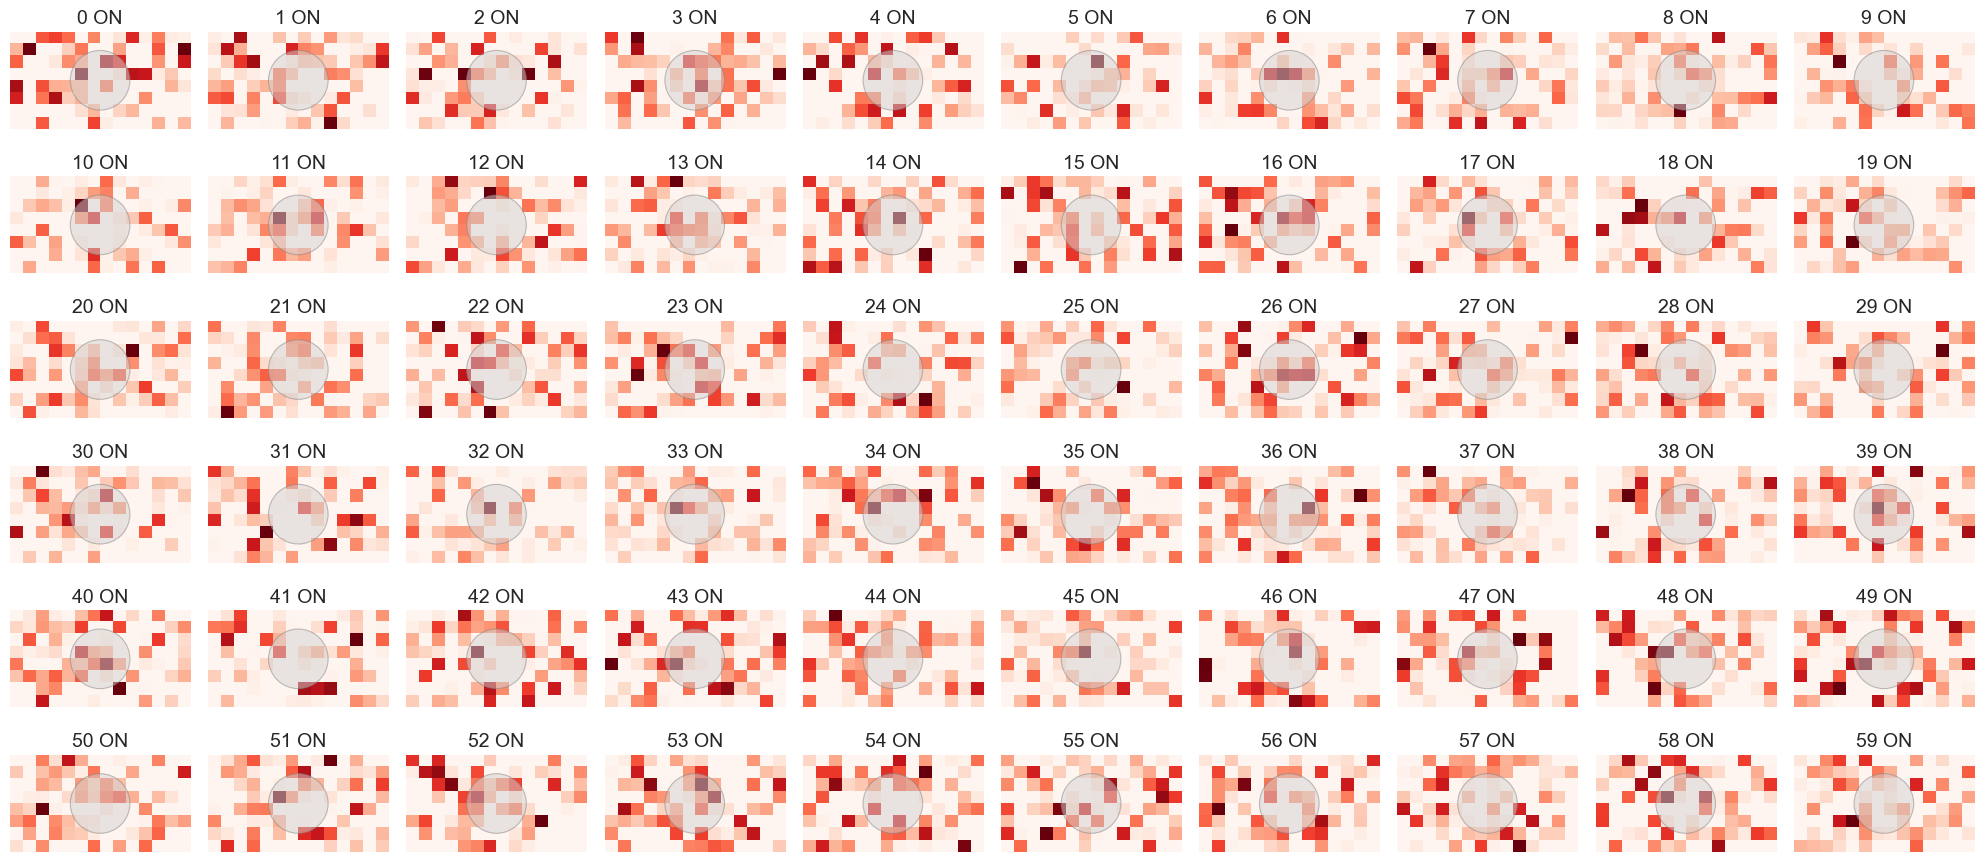

In [31]:
plot_on = True
cmap = "Reds" if plot_on else "Blues"
pixel_idx = slice(lsn.n_pixels) if plot_on else slice(lsn.n_pixels, 2*lsn.n_pixels)

# rois_to_show = len(valid_rois) # Show all ROIs
n_rois_to_show = min(len(valid_rois), 60)

ncols = 10
nrows = int(np.ceil(n_rois_to_show / ncols))
fig, axs = plt.subplots(figsize=(2*ncols, 1.5*nrows), nrows=nrows, ncols=ncols)
axs = axs.flatten()
imshow_extent = [lsn.azimuths[0], lsn.azimuths[-1], lsn.altitudes[0], lsn.altitudes[-1]]

for i, ax in enumerate(axs):
    ax.axis("off")

    if i < n_rois_to_show:
        roi = valid_rois[i]
        rf = sta_z_score.sel(roi=roi, pixel=pixel_idx).values.reshape(lsn.image_shape)
        rf /= rf.max()

        ax.add_patch(plt.Circle((0, 0), 20, edgecolor="gray", facecolor="lightgray", alpha=0.5))
        ax.imshow(rf, cmap=cmap, extent=imshow_extent, vmin=0, vmax=1)
        ax.set_title(f"{roi} {'ON' if plot_on else 'OFF'}")

# fig.suptitle("ON" if plot_on else "OFF")
fig.tight_layout()

In [103]:
def plot_gaussian_fit_rf(rf, ax):
    height, center_y, center_x, width_y, width_x, rotation = fitgaussian2D(rf)
    area = np.pi * (3/2)**2 * np.abs(width_x) * np.abs(width_y)
    ax.scatter(center_x, center_y)
    ax.add_patch(mpl.patches.Ellipse((center_x, center_y), width=abs(width_x), height=abs(width_y), angle=rotation, edgecolor="gray", facecolor="lightgray", alpha=0.35))

IndexError: index -25 is out of bounds for axis 1 with size 14

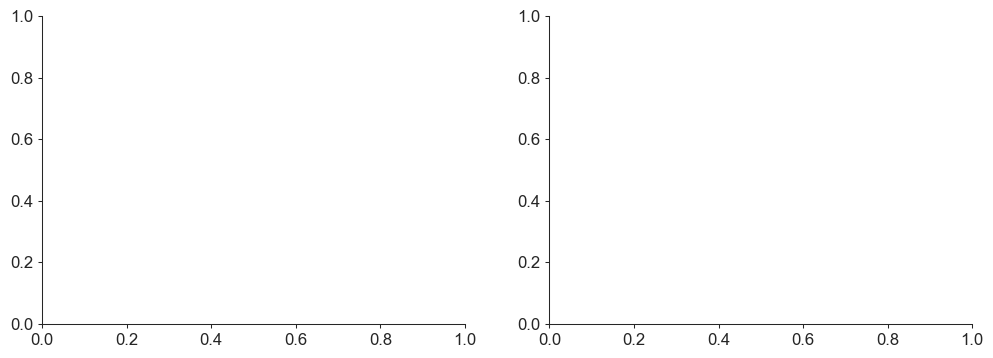

In [107]:
# Plot only a single ROI
roi = 6
fig, (ax_on, ax_off) = plt.subplots(figsize=(12, 4), ncols=2)

rf_on = sta[:lsn.n_pixels, roi].reshape(lsn.image_shape)
rf_on /= rf_on.max()
plot_gaussian_fit_rf(rf_on, ax_on)
ax_on.add_patch(plt.Circle((0, 0), 20, edgecolor="gray", facecolor="lightgray", alpha=0.35))
ax_on.imshow(rf_on, cmap="Reds", extent=imshow_extent, vmin=0, vmax=1)
ax_on.set_title("ON")

rf_off = sta[lsn.n_pixels:, roi].reshape(lsn.image_shape)
rf_off /= rf_off.max()
ax_off.add_patch(plt.Circle((0, 0), 20, edgecolor="gray", facecolor="lightgray", alpha=0.35))
ax_off.imshow(rf_off, cmap="Blues", extent=imshow_extent, vmin=0, vmax=1)
ax_off.set_title("OFF")

fig.suptitle(f"ROI {roi}")
fig.tight_layout()

In [109]:
fitgaussian2D(rf_on)

IndexError: index -25 is out of bounds for axis 1 with size 14

In [86]:
from scipy import optimize


class GaussianFitError(RuntimeError): pass


def gaussian2D(height, center_x, center_y, width_x, width_y, rotation):
    '''Build a function which evaluates a scaled 2d gaussian pdf
    Parameters
    ----------
    height : float
        scale factor
    center_x : float
        first coordinate of mean
    center_y : float
        second coordinate of mean
    width_x : float
        standard deviation along x axis
    width_y : float
        standard deviation along y axis
    rotation : float
        degrees clockwise by which to rotate the gaussian
    Returns
    -------
    rotgauss: fn
      parameters are x and y positions (row/column semantics are set by your 
      inputs to this function). Return value is the scaled gaussian pdf 
      evaluated at the argued point.
    '''

    width_x = float(width_x)
    width_y = float(width_y)
    
    rotation = np.deg2rad(rotation)
    center_xp = center_x*np.cos(rotation) - center_y*np.sin(rotation)
    center_yp = center_x*np.sin(rotation) + center_y*np.cos(rotation)
    
    def rotgauss(x,y):
        xp = x*np.cos(rotation) - y*np.sin(rotation)
        yp = x*np.sin(rotation) + y*np.cos(rotation)
        g = height*np.exp(-((center_xp-xp)/width_x)**2/2.0 - ((center_yp-yp)/width_y)**2/2.)
        return g
    return rotgauss
            

def moments2(data):
    '''Treating input image data as an independent multivariate gaussian, 
    estimate mean and standard deviations
    Parameters
    ----------
    data : np.ndarray
        2d numpy array.
    Returns
    -------
    height : float
        The maximum observed value in the data
    y : float
        Mean row index
    x : float
        Mean column index
    width_y : float
        The standard deviation along the mean row 
    width_x : float
        The standard deviation along the mean column
    None : 
        This function returns an instance of None.
    Notes
    -----
    uses original method from website for finding center
    '''

    total = data.sum()

    Y,X = np.indices(data.shape)
    x = ( X * data ).sum() / total
    y = ( Y * data ).sum() / total

    col = data[:, int(np.around(x))]
    width_x = np.sqrt( abs( ( np.arange(col.size) - y ) ** 2 * col ).sum() / col.sum() )

    row = data[int(np.around(y)), :]
    width_y = np.sqrt( abs( ( np.arange(row.size) - x ) ** 2 * row  ).sum() / row.sum() )

    height = data.max()

    return height, y, x, width_y, width_x, None
    

def fitgaussian2D(data):
    '''Fit a 2D gaussian to an image
    Parameters
    ----------
    data : np.ndarray
        input image
    Returns
    -------
    p2 : list
        height
        row mean
        column mean
        row standard deviation
        column standard deviation
        rotation
    
    Notes
    -----
    see gaussian2D for details about output values
    '''

    params = moments2(data)
    def errorfunction(p):
        p2 = np.array([p[0], params[1], params[2], np.abs(p[1]), np.abs(p[2]), p[3]])


        val = np.ravel(gaussian2D(*p2)(*np.indices(data.shape)) - data)

        return (val**2).sum()

    res = optimize.minimize(errorfunction, [ params[0], params[3], params[4], 0.0 ], method='Nelder-Mead', options={'maxfev':2500})
    p = res.x
    p2 = np.array([p[0], params[1], params[2], np.abs(p[1]), np.abs(p[2]), p[3]])
    success = res.success
    if not success and res.status != 2: # Status 2 is loss of precision; might need to handle this separately instead of passing...
        print(success)
        print(res.message)
        print(res.status)
        raise GaussianFitError('Gaussian optimization failed to converge:\n%s' % res.message)

    return p2